# Assumptions about this code. The NB was launched, with a command that mounts two volumes inside it.
``` bash
cd ~/git/neuronunit; sudo docker run -it -v `pwd`:/home/jovyan/neuronunit -v ~/git/BluePyOpt:/home/jovyan/BluePyOpt neuronunit-optimization /bin/bash'
```
# Bootstrap the ipython cluster via operating system shell utils:
This notebook needs 3 kernel restart and runs before it runs to completion for reasons that are unclear. Wait about 15 seconds between each kernel restart.

In [1]:
import os
os.system('jupyter trust test_ga_versus_grid.ipynb')
os.system('ipcluster start -n 8 --profile=default & sleep 15 ; python stdout_worker.py &')



0

In [2]:
import matplotlib
%matplotlib inline
import ipyparallel as ipp
rc = ipp.Client(profile='default')
from ipyparallel import depend, require, dependent
dview = rc[:]

################
# GA parameters:
about 25*15=375 models will be made, excluding rheobase search.
################


# Choice of selection criteria is important. 
Here we use BluepyOpts IBEA, such that it can be compared to NSGA2.

https://link.springer.com/article/10.1007/s00500-005-0027-5



In [3]:
MU = 15; NGEN = 50; CXPB = 0.9
USE_CACHED_GA = True

################
# Grid search parameters:
2^10=1024 models, will be made excluding rheobase search
################

In [4]:
npoints = 2
nparams = 10
from neuronunit.optimization.model_parameters import model_params
provided_keys = list(model_params.keys())
USE_CACHED_GS = True


An oppurtunity to improve grid search, by increasing resolution of search intervals given a first pass:

In [5]:
REFINE_GRID = True

In [6]:
import pickle
import numpy as np

In [7]:
from neuronunit.optimization.nsga_object import NSGA
from neuronunit.optimization import exhaustive_search as es
from neuronunit.optimization import evaluate_as_module as eam


Getting Rheobase cached data value for from AIBS dataset 354190013
/home/jovyan/neuronunit/neuronunit/optimization/neuroelectro.pickle got here
/home/jovyan/neuronunit/neuronunit/optimization
attempting to recover from pickled file
/home/jovyan/neuronunit/neuronunit/models/__init__.py


/home/jovyan/neuronunit/neuronunit/models/backends.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.5/site-packages/zmq/even

In [17]:

if USE_CACHED_GA:

    from deap import creator
    from deap import base
    from neuronunit.optimization import evaluate_as_module as eam
    from bluepyopt.deapext.optimisations import DEAPOptimisation
    DO = DEAPOptimisation()
    DO.setnparams(nparams = nparams, provided_keys = provided_keys)
    [pop, log, history, hof, td] = pickle.load(open('ga_dump.p','rb'))
    print(td, 'td')
    print(hof[0])
    tl = td
    print('tl', tl)
    #tl = [ v for v in td.values() ]
    #print(tl)

else:
    from bluepyopt.deapext.optimisations import DEAPOptimisation
    print(DEAPOptimisation)
    DO = DEAPOptimisation()
    DO.setnparams(nparams = nparams, provided_keys = provided_keys)
    pop, hof, log, history, td = DO.run(offspring_size = MU, max_ngen = NGEN, cp_frequency=4,cp_filename='checkpointedGA.p')
    with open('ga_dump.p','wb') as f:
       pickle.dump([pop, log, history, hof, td],f)
    

['vt', 'd', 'b', 'vpeak', 'v0', 'C', 'c', 'a', 'vr', 'k']
[-50.0, 0.050000000000000003, -5.0000000000000001e-09, 30.0, -75.0, 9.0000004500000001e-05, -60.0, 0.0, -75.0, 0.00063000000000000003]
[-30.0, 0.20000000000000001, -2.5000000000000001e-09, 40.0, -45.0, 0.0001100000055, -55.0, 0.94499999999999995, -50.0, 0.0014]
['vt', 'd', 'b', 'vpeak', 'v0', 'C', 'c', 'a', 'vr', 'k']
['C', 'd', 'v0', 'vr', 'a', 'k', 'vpeak', 'b', 'c', 'vt'] td
[0.00010857364465021192, 0.16335163313262221, -67.559828504579158, -56.652023872552057, 0.52306950985533196, 0.0013561207274400491, 30.60616432706485, -4.2696391992397188e-09, -59.543378763173926, -39.935169294859186]
tl ['C', 'd', 'v0', 'vr', 'a', 'k', 'vpeak', 'b', 'c', 'vt']


In [18]:
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size':16})
import matplotlib.pyplot as plt
all_inds = history.genealogy_history.values()
sums = np.array([np.sum(ind.fitness.values) for ind in all_inds])
quads = []
#from neuronunit.optimization import evaluate_as_module as eam
#td = DO.get_trans_list(DO.params)

#td = eam.get_trans_dict(NSGAO.subset)
for k in range(1,9):
    for i,j in enumerate(td):
        if i+k < 10:
            quads.append((td[i],td[i+k],i,i+k))
all_inds1 = list(history.genealogy_history.values())


def plot_surface(x,z,td):
    ab = [ (all_inds1[x],all_inds1[z]) for y in all_inds1 ]
    xs = np.array([ind[x] for ind in all_inds])
    ys = np.array([ind[z] for ind in all_inds])
    min_ys = ys[np.where(sums == np.min(sums))]
    min_xs = xs[np.where(sums == np.min(sums))]
    plt.clf()
    fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')
    trip_axis = ax_trip.tripcolor(xs,ys,sums,20,norm=matplotlib.colors.LogNorm())
    plot_axis = ax_trip.plot(list(min_xs), list(min_ys), 'o', color='lightblue',label='global minima')
    fig_trip.colorbar(trip_axis, label='Sum of Objective Errors ')
    ax_trip.set_xlabel('Parameter '+str((td[x])))
    ax_trip.set_ylabel('Parameter '+str((td[z])))
    plot_axis = ax_trip.plot(list(min_xs), list(min_ys), 'o', color='lightblue')
    fig_trip.tight_layout()
    plt.savefig('surface'+str((td[z])+str('.png')))


# Below two error surface slices from the hypervolume are plotted.
The data that is plotted consists of the error as experienced by the GA.
Note: the GA performs an incomplete, and efficient sampling of the parameter space, and therefore sample points are irregularly spaced. Polygon interpolation is used to visualize error gradients. Existing plotting code from the package BluePyOpt has been extended for this purpose.
Light blue dots indicate local minima's of error experienced by the NSGA algrorithm.

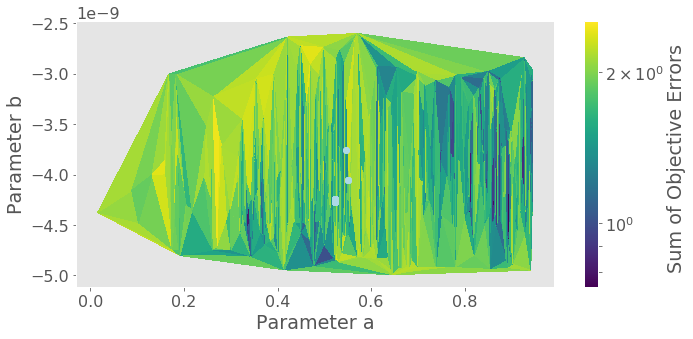

In [19]:
plot_surface(4,-3,td)

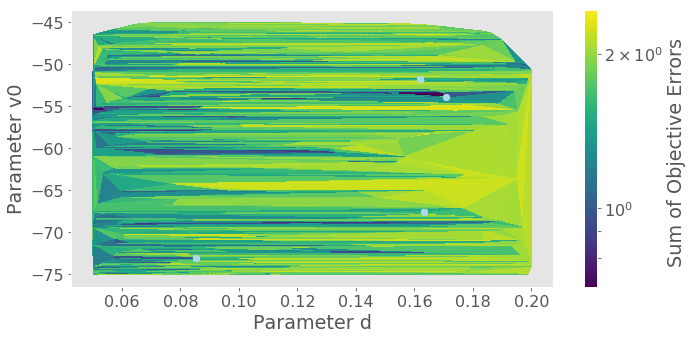

In [20]:

plot_surface(1,2,td)

In [21]:
if USE_CACHED_GS:
       #dtcpopg = pickle.load(open('grid_dump.p','rb'))
    import pickle
    #grid_dump_second_3rd.p
    first_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_first_3rd.p','rb'))
    second_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_second_3rd.p','rb'))
    final_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_final_3rd.p','rb'))

    second_third.extend(first_third)
    second_third.extend(final_third)
    dtcpopg = second_third

else:
    from neuronunit.optimization import exhaustive_search
    grid_points = exhaustive_search.create_grid(npoints = npoints,nparams = nparams)#,provided_keys = provided_keys )

    #grid_points = exhaustive_search.create_grid(npoints = npoints,nparams = nparams,provided_keys = provided_keys )
    dlist = list(dview.map_sync(exhaustive_search.update_dtc_pop,grid_points))
    from neuronunit.optimization import get_neab
    for d in dlist:
        d.model_path = get_neab.LEMS_MODEL_PATH
        d.LEMS_MODEL_PATH = get_neab.LEMS_MODEL_PATH

    # this is a big load on memory so divide it into thirds.

    dlist_first_third = dlist[0:int(len(dlist)/3)]
    dlist_second_third = dlist[int(len(dlist)/3):int(2*len(dlist)/3)]
    dlist_final_third = dlist[int(2*len(dlist)/3):-1]
    from neuronunit.optimization.exhaustive_search import dtc_to_rheo
    from neuronunit.optimization.exhaustive_search import parallel_method


    def compute_half(dlist_half):
        dlist_half = list(map(dtc_to_rheo,dlist_half))
        dlist_half = dview.map_sync(parallel_method,dlist_half)
        return dlist_half

    dlist_first_3rd = compute_half(dlist_first_third)
    import pickle
    with open('grid_dump_first_3rd.p','wb') as f:
       pickle.dump(dlist_first_3rd,f)
    # Garbage collect a big memory burden.
    dlist_first_3rd = None
    dlist_second_3rd = compute_half(dlist_second_third)

    with open('grid_dump_second_3rd.p','wb') as f:
       pickle.dump(dlist_second_3rd,f)
   # Garbage collect a big memory burden.
    dlist_second_3rd = None

    dlist_final_3rd = compute_half(dlist_final_third)
    with open('grid_dump_final_3rd.p','wb') as f:
       pickle.dump(dlist_final_3rd,f)
    # Garbage collect a big memory burden.
    dlist_final_3rd = None
    first_third = pickle.load(open('grid_dump_first_3rd.p','rb'))
    second_third = pickle.load(open('grid_dump_second_3rd.p','rb'))
    final_third = pickle.load(open('grid_dump_final_3rd.p','rb'))

    second_third.extend(first_third)
    second_third.extend(final_third)
    dtcpopg = second_third

    


In [22]:
dtcpopg = [ dtc for dtc in dtcpopg if not None in (dtc.scores.values()) ]
dtcpopg = [ (dtc,sum(list(dtc.scores.values()))) for dtc in dtcpopg ]
sorted_grid = sorted(dtcpopg,key=lambda x:x[1])
sorted_grid = [dtc[0] for dtc in sorted_grid]
mini = dtcpopg[0][1]
maxi = dtcpopg[-1][1]
minimagr = sorted_grid[0]
minimagr_dtc = sorted_grid[0]
minimagr_dtc_1 = sorted_grid[1]
minimagr_dtc_2 = sorted_grid[2]

from neuronunit.optimization.exhaustive_search import create_refined_grid
refined_grid = create_refined_grid(minimagr_dtc, minimagr_dtc_1,minimagr_dtc_2)



/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


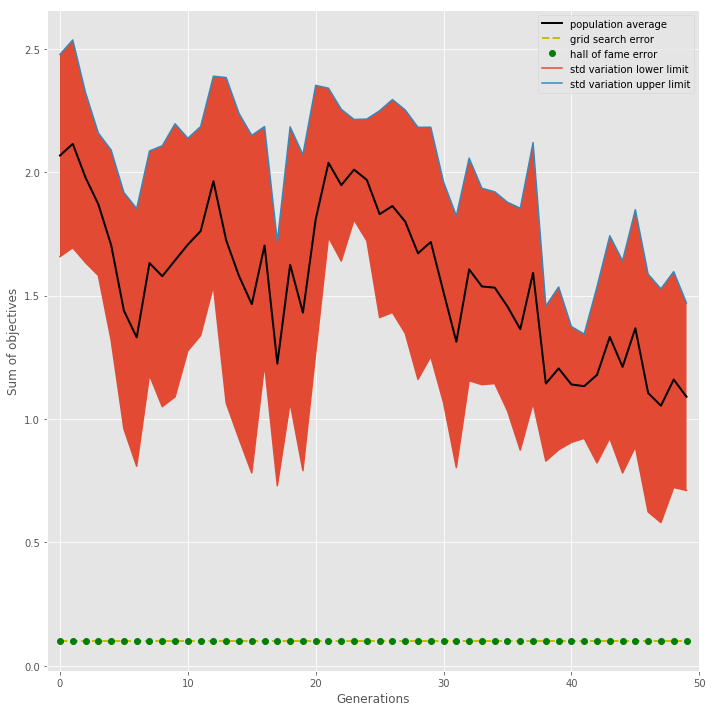

In [23]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#log = logbook
#plt.clf()
plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
gen_numbers =[ i for i in range(0,len(log.select('gen'))) ]
mean = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('avg')])
std = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('std')])
minimum = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('min')])
best_line = np.array([ np.sqrt(np.mean(np.square(list(p.fitness.values))))  for p in hof])

bl = [b for b in best_line if not np.isnan(b) ] 
bl = [ min(bl) for i in gen_numbers]
blg = [ np.sqrt(np.mean(np.square(list(hof[0].fitness.values)))) for i in gen_numbers ]

#print(best_line)

#worst_line = np.array([ maxiga for i in gen_numbers])
#print(best_line)
#print(worst_line)

stdminus = mean - std
stdplus = mean + std
try:
    assert len(gen_numbers) == len(stdminus) == len(stdplus)
except:
    pass

axes.plot(
    gen_numbers,
    mean,
    color='black',
    linewidth=2,
    label='population average')
axes.fill_between(gen_numbers, stdminus, stdplus)
axes.plot(gen_numbers, blg,'y--', linewidth=2,  label='grid search error')
axes.plot(gen_numbers, bl, 'go', linewidth=2, label='hall of fame error')

axes.plot(gen_numbers, stdminus, label='std variation lower limit')
axes.plot(gen_numbers, stdplus, label='std variation upper limit')

axes.set_xlim(np.min(gen_numbers) - 1, np.max(gen_numbers) + 1)
axes.set_xlabel('Generations')
axes.set_ylabel('Sum of objectives')
axes.legend()
fig.tight_layout()
fig.show()

# Comment on plot
The plot shows the mean error value of the population as the GA evolves it's population. The red interval at any instant is the standard deviation of the error. The fact that the mean GA error is able to have a net upwards trajectory, after a net downwards trajectory, demonstrates that the GA retains a drive to explore, and is resiliant against being stuck in a local minima.

The following plot shows how population diversity (std deviation) increases,
and simultaneously mean error follows a net downward
Trajectory.

In [24]:
print(td)
def pop2dtc(pop1,DO,td):
    '''
    This function takes the DEAP population data type, and converts it to a more convenient
    data transport object, which can more readily be used in plotting functions.
    This a wasteful, recompute, which is in part necessitated because
    deaps pareto front object, only returns gene individual objects (elements of population)
    '''
    from neuronunit.optimization import evaluate_as_module as eam
    from neuronunit.optimization import nsga_parallel
    DO.td = td
    assert DO.td == td
    return_package = nsga_parallel.update_pop(pop1,td)
    dtc_pop = []
    for i,r in enumerate(return_package):
        dtc_pop.append(r[0])
        dtc_pop[i].error = None
        dtc_pop[i].error = np.sqrt(np.mean(np.square(list(pop1[i].fitness.values))))
    sorted_list  = sorted([(dtc,dtc.error) for dtc in dtc_pop],key=lambda x:x[1])
    dtc_pop = [dtc[0] for dtc in sorted_list]
    print(dtc_pop,sorted_list)
    return dtc_pop

DO.td = td
print(hof[0])
print(len(hof))
dtc_pop = pop2dtc(hof[0:-1],DO,td)

miniga = dtc_pop[0].error
maxiga = dtc_pop[-1].error
maximaga = dtc_pop[-1]
minimaga = dtc_pop[0]

CACHE_PF = False

['C', 'd', 'v0', 'vr', 'a', 'k', 'vpeak', 'b', 'c', 'vt']
[0.00010857364465021192, 0.16335163313262221, -67.559828504579158, -56.652023872552057, 0.52306950985533196, 0.0013561207274400491, 30.60616432706485, -4.2696391992397188e-09, -59.543378763173926, -39.935169294859186]
10
Mechanisms already loaded from path: /home/jovyan/neuronunit/neuronunit/models/NeuroML2.  Aborting.

    Starting simulation in NEURON of 500.0ms generated from NeuroML2 model...

Population RS_pop contains 1 instance(s) of component: RS of type: izhikevich2007Cell
Ratio = 0.74
<class 'sciunit.scores.RatioScore'>
{'vpeak': 30.60616432706485, 'v0': -67.559828504579158, 'C': 0.00010857364465021192, 'c': -59.543378763173926, 'vt': -39.935169294859186, 'd': 0.16335163313262221, 'b': -4.2696391992397188e-09, 'a': 0.52306950985533196, 'vr': -56.652023872552057, 'k': 0.0013561207274400491} {'vt': -39.935169294859186, 'd': 0.16335163313262221, 'b': -4.2696391992397188e-09, 'vpeak': 30.60616432706485, 'v0': -67.559828504

In [25]:

if CACHE_PF == False:
    h = list(history.genealogy_history.values())
    evaluated_history = []
    for i in h:
        if hasattr(i,'rheobase'):
            i.error = None
            i.error = np.sqrt(np.mean(np.square(list(i.fitness.values))))
            evaluated_history.append(i)
    sorted_list  = sorted([(i,i.error) for i in evaluated_history ],key=lambda x:x[1])

    with open('pf_dump.p','wb') as f:
       pickle.dump([ sorted_list, evaluated_history ],f)
else: 
     
     unpack = pickle.load(open('pf_dump.p','rb'))
     print(unpack)
     sorted_list_pf = unpack[0]
     pareto_dtc = unpack[1] 

minimaga_ind = sorted_list[0][0]
maximaga_ind = sorted_list[-1][0]
miniga = sorted_list[0][1]
maxiga = sorted_list[-1][1]


In [26]:
print(miniga)
print(maxiga)
print(minimaga_ind.fitness.values)
print(maximaga_ind.fitness.values)
print(len(minimaga_ind.fitness.values))
#print(minimaga_ind[1].rheobase)
print(dtcpopg[0][0].rheobase)
print(dtcpopg[0][0].scores)
print(sorted_list[-1][0].rheobase)
print(sorted_list[-1][0].fitness.values)



0.101837993419
0.526601065386
(0.012744951963968187, 0.001978363336640254, 0.05554160625691573, 0.1934863252116903, 0.042666083687587175, 0.17324824782589665, 0.00856226967993301)
(0.048630595131726184, 0.27738785934707055, 0.037776537930737986, 0.7895378313892487, 0.8519701710458485, 0.7148912308713938, 0.011494208183711496)
7
{'value': array(375.0) * pA}
{'TimeConstantTest': 0.0001599183571610041, 'RestingPotentialTest': 0.9228226674484319, 'InjectedCurrentAPAmplitudeTest': 0.07895802916155481, 'InjectedCurrentAPWidthTest': 0.7289064948808044, 'CapacitanceTest': 0.2290729774235224, 'InputResistanceTest': 0.19336266603775787, 'RheobaseTestP': 0.6454531177947831}
{'value': array(70.3125) * pA}
(0.048630595131726184, 0.27738785934707055, 0.037776537930737986, 0.7895378313892487, 0.8519701710458485, 0.7148912308713938, 0.011494208183711496)


Mechanisms already loaded from path: /home/jovyan/neuronunit/neuronunit/models/NeuroML2.  Aborting.

    Starting simulation in NEURON of 500.0ms generated from NeuroML2 model...

Population RS_pop contains 1 instance(s) of component: RS of type: izhikevich2007Cell
1 True


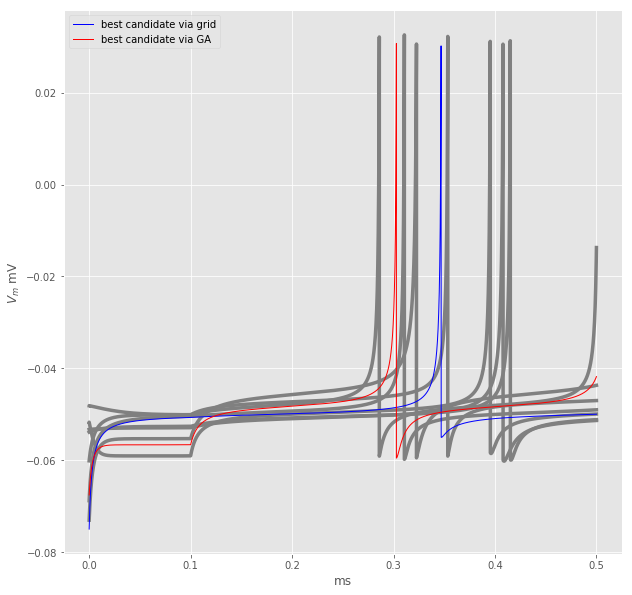

In [27]:
def use_dtc_to_plotting(dtcpop,minimagr):
    from neuronunit.capabilities import spike_functions
    import matplotlib.pyplot as plt
    import numpy as np
    plt.clf()
    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
    stored_min = []
    stored_max = []
    for dtc in dtcpop[1:-1]:
        plt.plot(dtc.tvec, dtc.vm0,linewidth=3.5, color='grey')
        stored_min.append(np.min(dtc.vm0))
        stored_max.append(np.max(dtc.vm0))
        
    from neuronunit.models.reduced import ReducedModel
    from neuronunit.optimization.get_neab import tests as T
    from neuronunit.optimization import get_neab
    from neuronunit.optimization import evaluate_as_module
    from neuronunit.optimization.evaluate_as_module import pre_format
    model = ReducedModel(get_neab.LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    import neuron
    model._backend.reset_neuron(neuron)
    model.set_attrs(minimagr.attrs)
    model.rheobase = minimagr.rheobase['value']
    minimagr = pre_format(minimagr)
    parameter_list = list(minimagr.vtest.values())
    model.inject_square_current(parameter_list[0])
    model._backend.local_run()
    assert model.get_spike_count() == 1
    print(model.get_spike_count(),bool(model.get_spike_count() == 1))
    brute_best = list(model.results['vm'])

    plt.plot(dtcpop[0].tvec, brute_best,linewidth=1, color='blue',label='best candidate via grid')#+str(mini.scores))
    plt.plot(dtcpop[0].tvec,dtcpop[0].vm0,linewidth=1, color='red',label='best candidate via GA')#+str(miniga.scores))
    plt.legend()
    plt.ylabel('$V_{m}$ mV')
    plt.xlabel('ms')
    plt.show()
from neuronunit import plottools
from neuronunit.plottools import dtc_to_plotting

CACHE_PLOTTING = False
if CACHE_PLOTTING == False:
    dtc_pop = dview.map_sync(dtc_to_plotting,dtc_pop )
    with open('plotting_dump.p','wb') as f:
       pickle.dump(dtc_pop,f)
else: 
     dtc_pop  = pickle.load(open('plotting_dump.p','rb'))

use_dtc_to_plotting(dtc_pop,minimagr_dtc)
            

# Comment on plot
There is good agreement between traces produced by the best candidate found by Genetic Algorithm, and exhaustive grid search.

In [36]:
print(dtc_pop[0].scores)
print(minimagr_dtc.scores)
print(sum(list(dtc_pop[0].scores.values())))
print(sum(list(minimagr_dtc.scores.values())))
miniga = sum(list(dtc_pop[0].scores.values()))
print(miniga)


{'TimeConstantTest': 0.032471017834430516, 'RestingPotentialTest': 0.002784164213486484, 'InjectedCurrentAPAmplitudeTest': 0.03875674066130441, 'InjectedCurrentAPWidthTest': 0.17772124357502883, 'CapacitanceTest': 0.2805223834217656, 'InputResistanceTest': 0.6566553449787913, 'RheobaseTestP': 0.8965087881051788}
{'TimeConstantTest': 0.7600485044952334, 'RestingPotentialTest': 0.005985027338458515, 'InjectedCurrentAPAmplitudeTest': 0.0450454996701426, 'InjectedCurrentAPWidthTest': 0.16455555946452027, 'CapacitanceTest': 0.13203570555680233, 'InputResistanceTest': 0.0, 'RheobaseTestP': 0.021429272693835322}
2.085419682789986
1.1290995692189925
2.085419682789986


# Quantize distance between minimimum error and maximum error.
This step will allow the GA's performance to be located within or below the range of error found by grid search.


In [37]:
print(maxi)
print(mini)
print(miniga)
quantize_distance = list(np.linspace(mini,maxi,10))

# check that the nsga error is in the bottom 1/5th of the entire error range.
print('Report: ')
print("Success" if bool(miniga < quantize_distance[0]) else "Failure")
print("The nsga error %f is in the bottom 1/5th of the entire error range" % miniga)
print("Minimum = %f; 20th percentile = %f; Maximum = %f" % (mini,quantize_distance[0],maxi))

2.1628706437621323
2.7987358711040153
2.085419682789986
Report: 
Success
The nsga error 2.085420 is in the bottom 1/5th of the entire error range
Minimum = 2.798736; 20th percentile = 2.798736; Maximum = 2.162871


The code below reports on the differences between between attributes of best models found via grid versus attributes of best models found via GA search:


In [42]:
from neuronunit.optimization import evaluate_as_module as eam
NSGAO = NSGA(0.85)
NSGAO.setnparams(nparams=nparams,provided_keys=provided_keys)
#td = eam.get_trans_dict(NSGAO.subset)
#print(td)
td = { v:k for k,v in enumerate(td) }
from neuronunit.optimization import model_parameters as modelp
mp = modelp.model_params
#minimaga = pareto_dtc[0]
for k,v in minimagr_dtc.attrs.items():
    #hvgrid = np.linspace(np.min(mp[k]),np.max(mp[k]),10)
    dimension_length = np.max(mp[k]) - np.min(mp[k])
    solution_distance_in_1D = np.abs(float(hof[0][td[k]]))-np.abs(float(v))
        
    #solution_distance_in_1D = np.abs(float(minimaga.attrs[k]))-np.abs(float(v))
    relative_distance = dimension_length/solution_distance_in_1D
    print('the difference between brute force candidates model parameters and the GA\'s model parameters:')
    print(float(hof[0][td[k]])-float(v),hof[0][td[k]],v,k)
    print('the relative distance scaled by the length of the parameter dimension of interest:')
    print(relative_distance)

    
    

the difference between brute force candidates model parameters and the GA's model parameters:
50.00010857364465 0.00010857364465 -50.0 vt
the relative distance scaled by the length of the parameter dimension of interest:
-0.400000868591
the difference between brute force candidates model parameters and the GA's model parameters:
0.11335163313262221 0.163351633133 0.05 d
the relative distance scaled by the length of the parameter dimension of interest:
1.32331573754
the difference between brute force candidates model parameters and the GA's model parameters:
-67.55982849957915 -67.5598285046 -5e-09 b
the relative distance scaled by the length of the parameter dimension of interest:
3.70042383991e-11
the difference between brute force candidates model parameters and the GA's model parameters:
-86.65202387255206 -56.6520238726 30.0 vpeak
the relative distance scaled by the length of the parameter dimension of interest:
0.375206027423
the difference between brute force candidates model par

In [45]:
print('the difference between the bf error and the GA\'s error:')
print('grid search:')
from numpy import square, mean, sqrt
rmsg = sqrt(mean(square(list(minimagr_dtc.scores.values()))))
print(rmsg)
print('ga:')
rmsga = sqrt(mean(square(list(dtc_pop[0].scores.values()))))
print(rmsga)
print('Hall of Fame front')
print(sqrt(mean(square(list(hof[0].fitness.values)))))
print(miniga)


the difference between the bf error and the GA's error:
grid search:
0.29873777804
ga:
0.438791538656
Hall of Fame front
0.101837993419
2.085419682789986


If any time is left over, may as well compute a more accurate grid, to better quantify GA performance in the future.

In [ ]:
print(refined_grid)
REFINED_GRID = True
if REFINE_GRID:
    #maximagr_dtc, maxi = sorted_dtcs(dtcpopg)[-1]

    dlist = list(dview.map_sync(exhaustive_search.update_dtc_pop,refined_grid))
    from neuronunit.optimization import get_neab
    for d in dlist:
        d.model_path = get_neab.LEMS_MODEL_PATH
        d.LEMS_MODEL_PATH = get_neab.LEMS_MODEL_PATH

    # this is a big load on memory so divide it into thirds.

    dlist_first_third = dlist[0:int(len(dlist)/3)]
    dlist_second_third = dlist[int(len(dlist)/3):int(2*len(dlist)/3)]
    dlist_final_third = dlist[int(2*len(dlist)/3):-1]
    from neuronunit.optimization.exhaustive_search import dtc_to_rheo
    from neuronunit.optimization.exhaustive_search import parallel_method


    def compute_half(dlist_half):
        dlist_half = list(map(dtc_to_rheo,dlist_half))
        dlist_half = dview.map_sync(parallel_method,dlist_half)
        return dlist_half

    dlist_first_3rd = compute_half(dlist_first_third)

    with open('grid_dump_first_3rd.p','wb') as f:
       pickle.dump(dlist_first_3rd,f)
    # Garbage collect a big memory burden.
    dlist_first_3rd = None
    dlist_second_3rd = compute_half(dlist_second_third)

    with open('grid_dump_second_3rd.p','wb') as f:
       pickle.dump(dlist_second_3rd,f)
    # Garbage collect a big memory burden.
    dlist_second_3rd = None

    dlist_final_3rd = compute_half(dlist_final_third)
    with open('grid_dump_final_3rd.p','wb') as f:
       pickle.dump(dlist_final_3rd,f)
    # Garbage collect a big memory burden.
    dlist_final_3rd = None